In [1]:
import pandas as pd
import numpy as np
import copy
import json
import psycopg2
import geopandas as gpd
import shapely
from shapely.geometry import box
from shapely.ops import split
from arcgis.gis import GIS
from arcgis import geocode
from arcgis.geometry import BaseGeometry, Geometry
import openai
from keybert.llm import OpenAI
from keybert import KeyLLM


In [2]:
%%time


@classmethod
def from_shapely(cls, shapely_geometry):
    return cls(shapely_geometry.__geo_interface__)

BaseGeometry.from_shapely = from_shapely

# init db connection
with open("awesome_db_key", "r") as f:
    database, host, user, password, port = f.read().splitlines()
    
conn = psycopg2.connect(database=database,
                        host=host,
                        user=user,
                        password=password,
                        port=port)
cursor = conn.cursor()


# init GIS connection
with open("agol_account_info.txt", "r") as f:
    url, username, password = f.read().splitlines()
    
gis = GIS(url, username=username, password=password)

# init llm connection
with open("openai_api_key", "r") as f:
    MY_API_KEY = f.readline()
    
    
# Create your LLM
client = openai.OpenAI(api_key=MY_API_KEY)
llm = OpenAI(client)

# Load it in KeyLLM
kw_model = KeyLLM(llm)


cursor.execute("""
SELECT id, city, community, zipcodes FROM public.community_neighborhoods
ORDER BY id ASC 
""")
db_out = cursor.fetchall()
community_neighborhoods_df = pd.DataFrame(db_out, columns =["id", "city", "community", "zipcodes"])

stop_words = ['neighborhood', 'region', 'location', 'geographic', 'geographical location', 'street', 'streets', 'landmarks', 'area', 'part', 'specific location']
directional_predictates = ['north', 'south', 'west', 'east']
arcgis_community_boundaries_lyr = gis.content.get("23a806fb906e428cb75d123cf2ab580c").layers[0]
community_boundaries_sdf = pd.DataFrame.spatial.from_layer(arcgis_community_boundaries_lyr)
fset = arcgis_community_boundaries_lyr.query()
gjson_string = fset.to_geojson
community_boundaries_gdf = gpd.read_file(gjson_string, driver='GeoJSON').set_crs(2230, allow_override=True)

# full name: includes north broadway and south braodway
sd_roads_gdf = gpd.read_file('sd_roads.json', driver='GeoJSON').set_crs(2230, allow_override=True)
bgs_gdf = gpd.read_file("bgs_sd_imp/bgs_sd_imp.shp").to_crs(2230)

Wall time: 4min 30s


<AxesSubplot: >

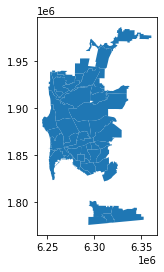

In [3]:
community_boundaries_gdf.plot()

In [4]:
import multiprocessing

In [11]:
sd_zip = gpd.read_file("zip_neigh/geo_export_4cffd5d9-200a-4e2d-abd0-7904bc10857a.shp")

In [14]:
sd_zip[sd_zip['community'] == "Chula Vista"]

,community,shape_star,shape_stle,zip,geometry
4,Chula Vista,4.034374e+08,112587.791814,91910.0,"POLYGON ((-117.06354 32.65011, -117.06345 32.6..."
5,Chula Vista,3.290440e+08,93108.695144,91911.0,"POLYGON ((-117.04641 32.62846, -117.04635 32.6..."
11,Chula Vista,2.982798e+08,98429.106684,91913.0,"POLYGON ((-116.97130 32.64594, -116.97130 32.6..."
12,Chula Vista,4.375973e+08,106378.940938,91914.0,"POLYGON ((-116.94945 32.68171, -116.94505 32.6..."
13,Chula Vista,5.557316e+08,118036.770869,91915.0,"POLYGON ((-116.93489 32.64316, -116.93488 32.6..."


In [5]:
geom_txt = "somewhere around north Del Mar Heights"

In [6]:
street_txt = "On El Cajon Blvd bewteen 63rd and 70th Street"

In [7]:
keywords = []
for _ in range(5):
    keywords += kw_model.extract_keywords(geom_txt)[0]


In [8]:
keywords = []
for _ in range(5):
    keywords += kw_model.extract_keywords(street_txt)[0]

In [9]:
set(keywords)

{'63rd Street',
 '70th Street',
 'Between',
 'El Cajon Blvd',
 'Location',
 'Neighborhood',
 'Specific address',
 'Street'}

In [10]:
#classification_id, keyword_text, city

In [20]:
# specify extent
geocode(address = "El Cajon Blvd" + ", San Diego", max_locations = 10)

[{'address': 'El Cajon Blvd, San Diego, California, 92115',
  'location': {'x': -117.065754570721, 'y': 32.762214735752},
  'score': 100,
  'attributes': {'Loc_name': 'World',
   'Status': 'T',
   'Score': 100,
   'Match_addr': 'El Cajon Blvd, San Diego, California, 92115',
   'LongLabel': 'El Cajon Blvd, San Diego, CA, 92115, USA',
   'ShortLabel': 'El Cajon Blvd',
   'Addr_type': 'StreetName',
   'Type': '',
   'PlaceName': '',
   'Place_addr': 'El Cajon Blvd, San Diego, California, 92115',
   'Phone': '',
   'URL': '',
   'Rank': 20,
   'AddBldg': '',
   'AddNum': '',
   'AddNumFrom': '',
   'AddNumTo': '',
   'AddRange': '',
   'Side': '',
   'StPreDir': '',
   'StPreType': '',
   'StName': 'El Cajon',
   'StType': 'Blvd',
   'StDir': '',
   'BldgType': '',
   'BldgName': '',
   'LevelType': '',
   'LevelName': '',
   'UnitType': '',
   'UnitName': '',
   'SubAddr': '',
   'StAddr': 'El Cajon Blvd',
   'Block': '',
   'Sector': '',
   'Nbrhd': 'College East',
   'District': '',
   

In [8]:
def get_extent(geom_id, geom_txt, conversation_id=None):
    if geom_id == 0:
        return get_community(geom_txt)
    elif geom_id == 1:
        return get_poi(geom_txt)
    elif geom_id == 2:
        return get_road(geom_txt)
    else:
        raise Exception("Invalid geom_id")


def get_community(geom_txt):
    dw_out = []
    community_out = []
    # multithread 
    # make a set
    
    while not len(community_out):
        # "somewhere around north Del Mar Heights"
        keywords = kw_model.extract_keywords(geom_txt)[0]
        # keywords = ["Del Mar Heights", "north", ...]
        for kw in copy.deepcopy(keywords):
            for dw in directional_predictates:
                if dw in kw.lower():
                    dw_out.append(dw)
                    keywords.remove(kw)
        print(keywords)
        
        
        for kw in keywords:    
            kw_community = community_neighborhoods_df[
                community_neighborhoods_df.apply(
                    lambda row: kw.lower() in row['community'].lower(), 
                    axis = 1)
            ]
            if len(kw_community):
                community_out.append(kw)
        
            
            
    geocode_out = []
    for kw in community_out:
        geocode_out.append(geocode(address = kw, max_locations = 10))
        
        
    ######################################################################
    # user in the loop
    # assertion
    # wait for user input
    
    ######################################################################
        
    # use try block and remove the community table block
    for g_out in geocode_out[0]:
        p = g_out['location']
        p = gpd.GeoSeries(shapely.Point(p['x'],  p['y'])).set_crs(4326).to_crs(2230)
        temp_gdf = community_boundaries_gdf[community_boundaries_gdf.geometry.contains(p[0])]
        if len(temp_gdf) > 0:
            # the geocode out are ranked in confidence score
            # break the first outcome is found
            break
    
    ### 
 
    community_shape = temp_gdf.geometry.iloc[0]
    x,y = community_shape.centroid.x, community_shape.centroid.y
    minx, miny, maxx, maxy = community_shape.bounds
    
    
    l1 = shapely.LineString([(x, miny), (x, maxy)])
    l2 = shapely.LineString([(minx, y), (maxx, y)])
    
    if len(dw_out) == 0:
        return community_shape
    
    out_poly = []
    for dw in dw_out:
        if dw in ['north', 'south']:
            split1, split2 = split(community_shape, l2).geoms
            if split1.centroid.y > split2.centroid.y:
                out_dict = {'north': split1, 'south': split2}
            else:
                out_dict = {'north': split2, 'south': split1}
        else:
            split1, split2 = split(community_shape, l1).geoms
            if split1.centroid.x < split2.centroid.x:
                out_dict = {'west': split1, 'east': split2}
            else:
                out_dict = {'west': split2, 'east': split1}
        out_poly.append(out_dict[dw])
        
    # TODO: RETURN GEOJSON
    return out_poly[0]
    

def get_poi(geom_txt):
    
    keywords = kw_model.extract_keywords(geom_txt)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = geocode(address = " ".join(keywords) + ", San Diego", max_locations = 1)[0]
    return gpd.GeoSeries(shapely.Point(geocode_out['location']['x'],  geocode_out['location']['y'])).set_crs(4326).to_crs(2230).buffer(500)[0]


def get_road(geom_txt):
    keywords = kw_model.extract_keywords(geom_txt)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = []
    # specify SD to be disambiguous for geocode
    for kw in keywords:
        geocode_out.append(geocode(address = kw + ", San Diego", max_locations = 1)[0]['location'])
    
    
    rd = []
    for g_out in geocode_out:
        p = gpd.GeoSeries(shapely.Point(g_out['x'],  g_out['y'])).set_crs(4326).to_crs(2230).buffer(100)
        rd.append(sd_roads_gdf[sd_roads_gdf.geometry.crosses(p[0])])
    
    out_road = []
    for r in rd:
        rd_name = r.RD20FULL.iloc[0]
        road_segments = sd_roads_gdf[sd_roads_gdf['RD20FULL'] == rd_name]['geometry'].tolist()
        temp_road = road_segments[0]
        for r in road_segments[1:]:
            temp_road = temp_road.union(r)
        out_road.append(temp_road)
        
    simple_rd = []
    for rd in out_road:
        minx, miny, maxx, maxy = rd.bounds
        if (maxy - miny) > (maxx - minx):
            x = rd.centroid.x
            simple_rd.append(shapely.LineString([(x, miny), (x, maxy)]))
        else:

            y = rd.centroid.y
            simple_rd.append(shapely.LineString([(minx, y), (maxx, y)]))
    
    
    rd_bound = []
    road = None
    for rd1 in simple_rd:
        count = 0
        for rd2 in simple_rd:
            if rd1.crosses(rd2): count += 1 
        if count == 2:
            for i, rd2 in enumerate(simple_rd):
                pt = rd1.intersection(rd2)
                if isinstance(pt, shapely.Point):
                    rd_bound.append(pt)
                else:
                    road = out_road[i]
            break
            
    idxmax = np.argmax(np.abs(np.array(rd_bound[0].bounds) - rd_bound[1].bounds))
    maxpt1, maxpt2 = rd_bound[0].xy[idxmax][0], rd_bound[1].xy[idxmax][0]
    minx, miny, maxx, maxy = road.bounds
    minx, maxx = min(maxpt1, maxpt2), max(maxpt1, maxpt2)
    
    out_road = box(minx, miny, maxx, maxy).intersection(road)
    
    return out_road.buffer(100)


def get_enrich_data(study_area, precision='block group'):
    # IF CALL ID EXISTS:
    # CHECK AWSM TABLE FOR EXISTING GEOJSON
    return bgs_gdf[bgs_gdf.geometry.intersects(study_area)]

def store_2_conv_id(conversation_id):
    # DB CALL

In [14]:
%%time
study_area = get_extent(2, "On El Cajon Blvd bewteen 63rd and 70th Street")

Wall time: 3.78 s


In [15]:
import folium

In [16]:
m = folium.Map([32.7, -117.2], zoom_start=10, tiles="cartodbpositron")

#folium.GeoJson(community_boundaries_gdf).add_to(m)
study_area_gjson = gpd.GeoSeries(study_area).simplify(tolerance=0.001).set_crs(2230)
folium.GeoJson(study_area_gjson, style_function=lambda x: {"fillColor": "red"}).add_to(m)
m

In [17]:
enrich_out = get_enrich_data(study_area)
enrich_out

,statefp,countyfp,tractce,blkgrpce,source_cou,aggregatio,population,apportionm,has_data,x2001_a,...,val400k_fy,val500k_fy,val750k_fy,val1m_fy,medval_fy,avgval_fy,valbase_fy,wlthindxcy,sei_cy,geometry
271,06,073,002902,2,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,443.34,...,7.0,176.0,28.0,9.0,647017.0,695815.0,227.0,33.0,40.9,"POLYGON ((6313191.002 1856790.043, 6313006.864..."
797,06,073,002902,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,740.74,...,11.0,258.0,26.0,43.0,1093023.0,1382797.0,622.0,76.0,43.7,"POLYGON ((6314488.135 1855555.998, 6314437.433..."
801,06,073,002904,2,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,354.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,50.2,"POLYGON ((6312442.113 1859089.978, 6312354.336..."
808,06,073,002904,3,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,344.44,...,2.0,43.0,5.0,2.0,648256.0,754386.0,57.0,29.0,53.9,"POLYGON ((6310487.060 1857777.887, 6310490.417..."
810,06,073,002905,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,427.12,...,1.0,18.0,94.0,2.0,853723.0,846552.0,116.0,37.0,29.8,"POLYGON ((6314614.927 1860357.937, 6314614.639..."
811,06,073,002905,3,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,680.86,...,36.0,255.0,8.0,2.0,630882.0,858524.0,393.0,68.0,53.8,"POLYGON ((6314416.069 1860283.060, 6314386.128..."
1266,06,073,002905,2,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,319.80,...,38.0,24.0,9.0,0.0,465789.0,498913.0,92.0,26.0,39.2,"POLYGON ((6316694.506 1859424.327, 6316222.044..."


In [18]:
m = folium.Map([32.7, -117.2], zoom_start=10, tiles="cartodbpositron")

folium.GeoJson(enrich_out.geometry.simplify(tolerance=0.001)).add_to(m)
folium.GeoJson(study_area_gjson, style_function=lambda x: {"color": "orange", "fillColor": "orange"}).add_to(m)
m